<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S6/S6_AssignmentSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required Libraries**


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
# simple function to upload files from local drive

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

**Data Transformations**


* Here I've created a Class to transform Train & Test Data. And I'm using Compose function to chain in all the transform operations required in the form of list and then pass it on the different sets of data.
* I have already set the mean and the standard deviation to 0.1307 & 0.3081 
* 2 main parameters normalize(boolean) and rotate(default value = 0).


In [0]:
# # Transformations 

# class Transformations():

#   def __init__(self, normalize=True, rotate = 0):
#       self.normalize = normalize
#       self.rotate = rotate


#   # For Train Data
#   def train_transforms(self, tensorToPIL = True):
#       self.tensorToPIL = tensorToPIL
#       transforms_list = []
#       transforms_list.append(transforms.ToTensor())
#       if self.normalize: 
#           transforms_list.append(transforms.Normalize((0.1307, ), (0.3081, )))
#       if self.rotate:
#           transforms_list.append(transforms.RandomRotation((-1*int(self.rotate), int(self.rotate)), fill=(1,)))
#       if self.tensorToPIL:
#           transforms_list.append(transforms.ToPILImage())
#       return transforms.Compose(transforms_list)


#   # For Test Data
#   def test_transforms(self, tensorToPIL = True):
#       self.tensorToPIL = tensorToPIL
#       transforms_list = [transforms.ToTensor()]
#       if self.normalize:
#           transforms_list.append(transforms.Normalize((0.1307, ),(0.3081, )))
#       if self.tensorToPIL:
#           transforms_list.append(transforms.ToPILImage())
#       return transforms.Compose(transforms_list)



# mnist_data = Transformations(normalize = True, rotate = 5)    # set normalize = True
# train_trans = mnist_data.train_transforms(tensorToPIL = True)  # Rotation of Train Images
# test_trans = mnist_data.test_transforms(tensorToPIL = True)

In [0]:
# Transformations

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                      #  transforms.ToPILImage()# The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      #  transforms.ToPILImage()
                                       ])


In [0]:
# Split Test & Train Data
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

**Dataloaders Arguments & Train/Test Dataloaders**

In [0]:
# DataLoaders

class Dataloader:
  def __init__(self, shuffle = True, batch_size = 128):
      cuda = torch.cuda.is_available()
      if cuda:
        torch.cuda.manual_seed(seed)
      self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) #if cuda else dict(shuffle=True, batch_size=64)

  def dataset_loader(self, data):
      return torch.utils.data.DataLoader(data, **self.dataloader_args) # **dataloader_args get passed when dataset_loader gets called


dl = Dataloader()

# train dataloader
train_loader = dl.dataset_loader(train)

# test dataloader
test_loader = dl.dataset_loader(test)

**Data Statistics**

torch.Size([128, 1, 28, 28])
torch.Size([128])


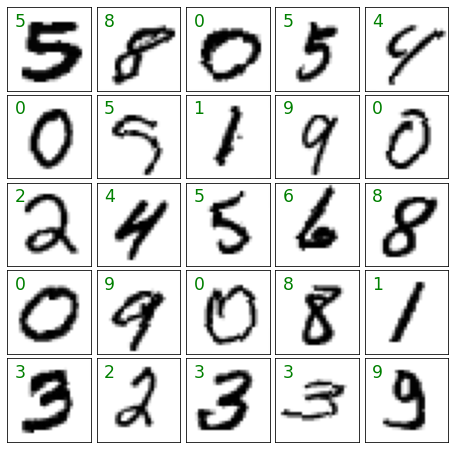

In [7]:

data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape) # [64, 1, 28, 28]
print(labels.shape) # [64]


from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline


def display_25(images, labels):
  figmatrix = plt.figure(figsize=(8, 8))
  row, col = 5, 5 # set rows & columns = 5
  gs = gridspec.GridSpec(row, col)
  gs.update(wspace=0.005, hspace=0.05)

  for i in range(1, 26):
    plt.subplot(gs[i-1])
    plt.tick_params( axis='both', which='both', labelbottom=False, labelleft=False, left=False, bottom=False)
    plt.imshow(images[i-1].numpy().squeeze(), cmap='gray_r')
    plt.text(2, 6, labels[i-1].numpy(), color="green", fontsize="xx-large")
  plt.show()

display_25(images[:25], labels[:25])



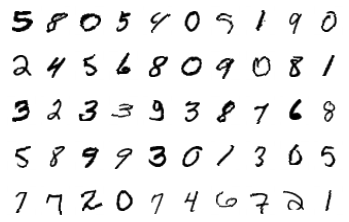

In [8]:
# Just curious at the orientation of these mnist images
figure = plt.figure()
num_of_images = 50
for i in range(1,num_of_images+1):
  plt.subplot(5,10, i)
  plt.axis('off')
  plt.imshow(images[i-1].numpy().squeeze(), cmap = 'gray_r')

In [0]:
# Main Model with Batch Normalization
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          nn.BatchNorm2d(8)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(10)) # O/P: 24

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 10
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 8
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 6

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0,  bias = False))
         

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(4))

    
    # Last Layer
      self.convblock9 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.08))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = self.convblock9(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)
      



**Model Summary**

In [10]:
# BN Model Summary 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
      self.test_acc.append(100. * correct / len(test_loader.dataset))



**Model 1**
#without L1 and L2 regularization with BN


In [0]:
def withoutL1_L2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#first model
  print('without L1 and L2 regularization with BN')

  model1= Test_Train()
  global loss1
  global acc1
  loss1 = model1.test_losses
  acc1 = model1.test_acc

  EPOCHS = 25 
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model1.train(model, device, train_loader, optimizer, epoch, scheduler)
      model1.test(model, device, test_loader,"model1.pt")



**Model 2**
#with L1 regularization with BN


In [0]:
def withL1_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#second model
  print('with L1 regularization with BN')

  model2 = Test_Train()
  global loss2
  global acc2
  loss2 = model2.test_losses
  acc2 = model2.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model2.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model2.test(model, device, test_loader,"model2.pt")

**Model 3**
#with L2 regularization with BN


In [0]:
def withL2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#third model
  print('with L2 regularization with BN')

  model3 = Test_Train()
  global loss3
  global acc3
  loss3 = model3.test_losses
  acc3 = model3.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model3.train(model, device, train_loader, optimizer, epoch, scheduler)
      model3.test(model, device, test_loader,"model3.pt")

**Model 4**
#with both L1 & L2 regularization with BN


In [0]:
def withL1_L2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#fourth  model
  print('with L1 & L2 regularization with BN')

  model4 = Test_Train()
  global loss4
  global acc4
  loss4 = model4.test_losses
  acc4 = model4.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model4.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model4.test(model, device, test_loader,"model4.pt")

In [16]:
modelTuple = iter(withoutL1_L2_BN(),
  withL1_BN())
 
print(modelTuple.__next__())

  0%|          | 0/469 [00:00<?, ?it/s]

without L1 and L2 regularization with BN
EPOCH: 1


Loss=0.05608420446515083 Batch_id=468 Accuracy=86.78: 100%|██████████| 469/469 [00:51<00:00,  9.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0659).  Saving model ...

Test set: Average loss: 0.0659, Accuracy: 9803/10000 (98.03%)

EPOCH: 2


Loss=0.039588987827301025 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0659 --> 0.0544).  Saving model ...

Test set: Average loss: 0.0544, Accuracy: 9835/10000 (98.35%)

EPOCH: 3


Loss=0.1356959044933319 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0544 --> 0.0429).  Saving model ...

Test set: Average loss: 0.0429, Accuracy: 9865/10000 (98.65%)

EPOCH: 4


Loss=0.02966737560927868 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:51<00:00,  9.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0429 --> 0.0349).  Saving model ...

Test set: Average loss: 0.0349, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.04642550274729729 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0349 --> 0.0321).  Saving model ...

Test set: Average loss: 0.0321, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.05052627623081207 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0321 --> 0.0306).  Saving model ...

Test set: Average loss: 0.0306, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.01638380065560341 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:51<00:00,  9.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0306 --> 0.0247).  Saving model ...

Test set: Average loss: 0.0247, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.14775294065475464 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:55<00:00,  8.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.013409181497991085 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:51<00:00,  9.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0247 --> 0.0236).  Saving model ...

Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.07270278036594391 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0236 --> 0.0225).  Saving model ...

Test set: Average loss: 0.0225, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.04866015911102295 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.028463982045650482 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0225 --> 0.0182).  Saving model ...

Test set: Average loss: 0.0182, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.02963620238006115 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:51<00:00,  9.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.010521366260945797 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.006668111775070429 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:51<00:00,  9.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.029221242293715477 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:51<00:00,  9.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0182 --> 0.0179).  Saving model ...

Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.03184843808412552 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:51<00:00,  9.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.032407473772764206 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:51<00:00,  9.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.001902501448057592 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:56<00:00,  8.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0179 --> 0.0155).  Saving model ...

Test set: Average loss: 0.0155, Accuracy: 9955/10000 (99.55%)

EPOCH: 20


Loss=0.0006009562057442963 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:51<00:00,  9.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9949/10000 (99.49%)

EPOCH: 21


Loss=0.005985513795167208 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:52<00:00,  8.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9948/10000 (99.48%)

EPOCH: 22


Loss=0.030001310631632805 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:52<00:00,  8.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0155 --> 0.0149).  Saving model ...

Test set: Average loss: 0.0149, Accuracy: 9951/10000 (99.51%)

EPOCH: 23


Loss=0.0010761319426819682 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:52<00:00,  8.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0149 --> 0.0144).  Saving model ...

Test set: Average loss: 0.0144, Accuracy: 9952/10000 (99.52%)

EPOCH: 24


Loss=0.0008390180300921202 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:52<00:00,  8.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0144 --> 0.0144).  Saving model ...

Test set: Average loss: 0.0144, Accuracy: 9952/10000 (99.52%)

EPOCH: 25


Loss=0.011766891926527023 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]


Validation loss has  decreased (0.0144 --> 0.0142).  Saving model ...

Test set: Average loss: 0.0142, Accuracy: 9954/10000 (99.54%)



  0%|          | 0/469 [00:00<?, ?it/s]

with L1 regularization with BN
EPOCH: 1


Loss=0.20811393857002258 Batch_id=468 Accuracy=87.34: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0713).  Saving model ...

Test set: Average loss: 0.0713, Accuracy: 9770/10000 (97.70%)

EPOCH: 2


Loss=0.03022330440580845 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0713 --> 0.0480).  Saving model ...

Test set: Average loss: 0.0480, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.027227189391851425 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0480 --> 0.0424).  Saving model ...

Test set: Average loss: 0.0424, Accuracy: 9865/10000 (98.65%)

EPOCH: 4


Loss=0.128861665725708 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0424 --> 0.0349).  Saving model ...

Test set: Average loss: 0.0349, Accuracy: 9893/10000 (98.93%)

EPOCH: 5


Loss=0.03580218553543091 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:53<00:00,  8.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0349 --> 0.0259).  Saving model ...

Test set: Average loss: 0.0259, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.05995500087738037 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.022540412843227386 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:52<00:00,  8.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0259 --> 0.0233).  Saving model ...

Test set: Average loss: 0.0233, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.0178462415933609 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.045783888548612595 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:53<00:00,  8.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0233 --> 0.0221).  Saving model ...

Test set: Average loss: 0.0221, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.04365142434835434 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0221 --> 0.0211).  Saving model ...

Test set: Average loss: 0.0211, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.2043832242488861 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0211 --> 0.0203).  Saving model ...

Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.041984476149082184 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0203 --> 0.0201).  Saving model ...

Test set: Average loss: 0.0201, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.017880737781524658 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0201 --> 0.0185).  Saving model ...

Test set: Average loss: 0.0185, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.0838894173502922 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.014299916103482246 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.06564111262559891 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.037920571863651276 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.053474061191082 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0185 --> 0.0180).  Saving model ...

Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.01801721379160881 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0180 --> 0.0169).  Saving model ...

Test set: Average loss: 0.0169, Accuracy: 9942/10000 (99.42%)

EPOCH: 20


Loss=0.027560267597436905 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:52<00:00,  8.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.01305890642106533 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:52<00:00,  8.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.03221691772341728 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:52<00:00,  8.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0169 --> 0.0159).  Saving model ...

Test set: Average loss: 0.0159, Accuracy: 9944/10000 (99.44%)

EPOCH: 23


Loss=0.013916132971644402 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:52<00:00,  9.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0159 --> 0.0150).  Saving model ...

Test set: Average loss: 0.0150, Accuracy: 9951/10000 (99.51%)

EPOCH: 24


Loss=0.018255075439810753 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:54<00:00,  8.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0150 --> 0.0148).  Saving model ...

Test set: Average loss: 0.0148, Accuracy: 9950/10000 (99.50%)

EPOCH: 25


Loss=0.014349337667226791 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s]



Test set: Average loss: 0.0151, Accuracy: 9946/10000 (99.46%)



TypeError: ignored

In [17]:
modelTuple34 = iter(
  withL2_BN(), 
  withL1_L2_BN())
 
print(modelTuple34.__next__())

  0%|          | 0/469 [00:00<?, ?it/s]

with L2 regularization with BN
EPOCH: 1


Loss=0.04426181688904762 Batch_id=468 Accuracy=86.92: 100%|██████████| 469/469 [00:51<00:00,  9.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0632).  Saving model ...

Test set: Average loss: 0.0632, Accuracy: 9811/10000 (98.11%)

EPOCH: 2


Loss=0.07431154698133469 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:52<00:00,  8.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0632 --> 0.0558).  Saving model ...

Test set: Average loss: 0.0558, Accuracy: 9818/10000 (98.18%)

EPOCH: 3


Loss=0.14457176625728607 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9828/10000 (98.28%)

EPOCH: 4


Loss=0.015478987246751785 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0558 --> 0.0283).  Saving model ...

Test set: Average loss: 0.0283, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.026651984080672264 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9884/10000 (98.84%)

EPOCH: 6


Loss=0.03364824131131172 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:53<00:00,  8.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.10339922457933426 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:53<00:00,  8.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


Loss=0.09998714923858643 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.0593680776655674 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:57<00:00,  8.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0283 --> 0.0196).  Saving model ...

Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

EPOCH: 10


Loss=0.00815931148827076 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.011554107069969177 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.0037480490282177925 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:53<00:00,  8.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.020969511941075325 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.008693043142557144 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0196 --> 0.0191).  Saving model ...

Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.006691120099276304 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0191 --> 0.0189).  Saving model ...

Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

EPOCH: 16


Loss=0.052219465374946594 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0189 --> 0.0172).  Saving model ...

Test set: Average loss: 0.0172, Accuracy: 9950/10000 (99.50%)

EPOCH: 17


Loss=0.0008571248617954552 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:53<00:00,  8.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.008013940416276455 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.015085116028785706 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:53<00:00,  8.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0172 --> 0.0162).  Saving model ...

Test set: Average loss: 0.0162, Accuracy: 9955/10000 (99.55%)

EPOCH: 20


Loss=0.008174712769687176 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:57<00:00,  8.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0162 --> 0.0158).  Saving model ...

Test set: Average loss: 0.0158, Accuracy: 9954/10000 (99.54%)

EPOCH: 21


Loss=0.0058906301856040955 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9957/10000 (99.57%)

EPOCH: 22


Loss=0.002381180180236697 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0158 --> 0.0152).  Saving model ...

Test set: Average loss: 0.0152, Accuracy: 9956/10000 (99.56%)

EPOCH: 23


Loss=0.04819801449775696 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9956/10000 (99.56%)

EPOCH: 24


Loss=0.031178519129753113 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:53<00:00,  8.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0152 --> 0.0151).  Saving model ...

Test set: Average loss: 0.0151, Accuracy: 9958/10000 (99.58%)

EPOCH: 25


Loss=0.03665750101208687 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]



Test set: Average loss: 0.0152, Accuracy: 9954/10000 (99.54%)



  0%|          | 0/469 [00:00<?, ?it/s]

with L1 & L2 regularization with BN
EPOCH: 1


Loss=0.08165290206670761 Batch_id=468 Accuracy=87.69: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0777).  Saving model ...

Test set: Average loss: 0.0777, Accuracy: 9752/10000 (97.52%)

EPOCH: 2


Loss=0.020846568048000336 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:54<00:00,  8.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0777 --> 0.0418).  Saving model ...

Test set: Average loss: 0.0418, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.2027573436498642 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0418 --> 0.0375).  Saving model ...

Test set: Average loss: 0.0375, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.028497181832790375 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.035168811678886414 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0375 --> 0.0291).  Saving model ...

Test set: Average loss: 0.0291, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.07115157693624496 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:57<00:00,  8.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.03770828619599342 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.028997907415032387 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:54<00:00,  8.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0291 --> 0.0264).  Saving model ...

Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.09175688773393631 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0264 --> 0.0264).  Saving model ...

Test set: Average loss: 0.0264, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.024484869092702866 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9911/10000 (99.11%)

EPOCH: 11


Loss=0.02138129062950611 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0264 --> 0.0241).  Saving model ...

Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.08125250041484833 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0241 --> 0.0237).  Saving model ...

Test set: Average loss: 0.0237, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.023609306663274765 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0237 --> 0.0230).  Saving model ...

Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.041378844529390335 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0230 --> 0.0200).  Saving model ...

Test set: Average loss: 0.0200, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.01391465775668621 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:54<00:00,  8.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.06121077015995979 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:56<00:00,  8.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.06415257602930069 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.02575107291340828 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.05518069490790367 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.03318838030099869 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0200 --> 0.0189).  Saving model ...

Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.026138365268707275 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0189 --> 0.0183).  Saving model ...

Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

EPOCH: 22


Loss=0.01289416290819645 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9949/10000 (99.49%)

EPOCH: 23


Loss=0.015715468674898148 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:53<00:00,  8.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0183 --> 0.0171).  Saving model ...

Test set: Average loss: 0.0171, Accuracy: 9951/10000 (99.51%)

EPOCH: 24


Loss=0.014429428614675999 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:53<00:00,  8.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9951/10000 (99.51%)

EPOCH: 25


Loss=0.01476298738270998 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]



Test set: Average loss: 0.0173, Accuracy: 9950/10000 (99.50%)



TypeError: ignored

In [0]:
import matplotlib.pyplot as plt


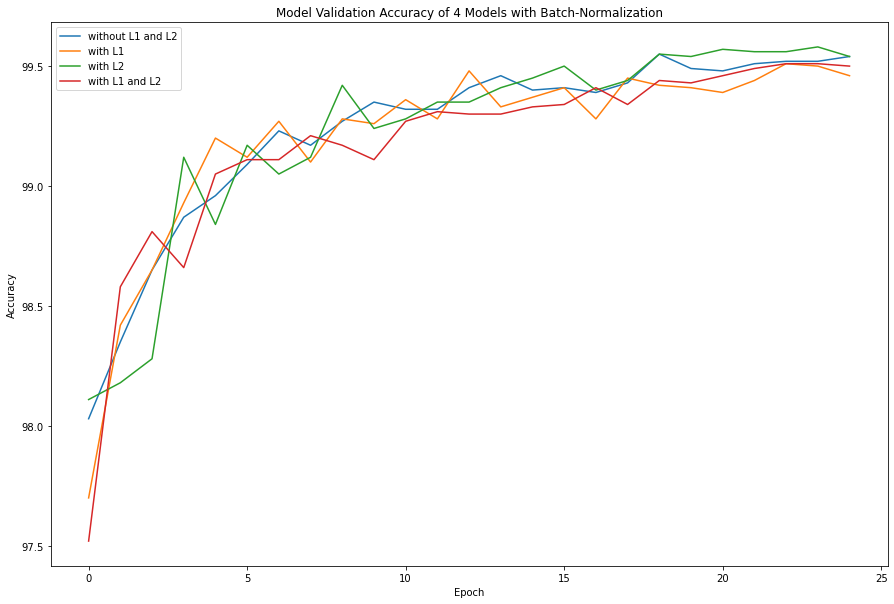

In [19]:
# Validation Accuracy 

class accuracy_plot(Test_Train):

  # a = Test_Train()
  
  def __init__(self):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(acc1)
    ax.plot(acc2)
    ax.plot(acc3)
    ax.plot(acc4)
    ax.set(title="Model Validation Accuracy of 4 Models with Batch-Normalization", xlabel="Epoch", ylabel="Accuracy")
    ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
    plt.savefig("Accuracyof4modelswithBN.png")
    plt.show()


b = accuracy_plot()
b

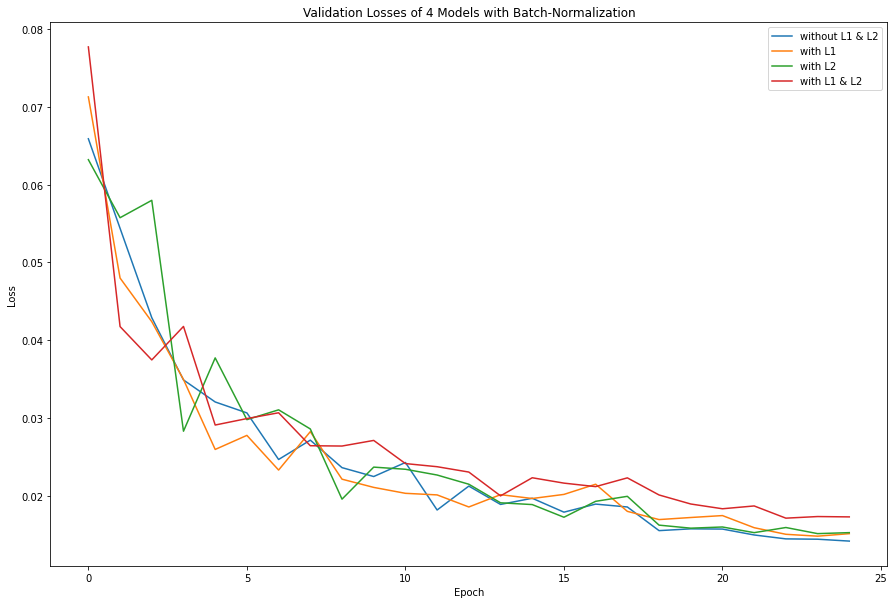

In [20]:
# Validation Loss

class loss_plot(Test_Train):
  def __init__(self):
    plt.figure(figsize = (15,10))
    ax = plt.subplot(111)
    ax.plot(loss1)
    ax.plot(loss2)
    ax.plot(loss3)
    ax.plot(loss4)
    ax.set(title='Validation Losses of 4 Models with Batch-Normalization', xlabel='Epoch', ylabel = 'Loss')
    ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
    plt.savefig('ValidationLossesBN.png')
    plt.show()

c = loss_plot()
c

In [0]:
# Misclassified Images

from google.colab import files
def misclassifiedOnes(model, filename):
  model = model.to(device)
  dataiter = iter(test_loader) 
  count = 0
  fig = plt.figure(figsize=(13,13))

  while count<25:
      images, labels = dataiter.next()
      images, labels = images.to(device), labels.to(device)
    
      output = model(images) 
      _, pred = torch.max(output, 1)   # convert output probabilities to predicted class
      images = images.cpu().numpy() # conv images to numpy format

      for idx in np.arange(128):
        if pred[idx]!=labels[idx]:
          ax = fig.add_subplot(5, 5, count+1, xticks=[], yticks=[])
          count=count+1
          ax.imshow(np.squeeze(images[idx]), cmap='cool')
          ax.set_title("Pred-{} (Target-{})".format(str(pred[idx].item()), str(labels[idx].item())), color="Black")
          if count==25:
            break
      plt.savefig(filename)
  files.download(filename)

   


Misclassifed Images from Model1
******************************


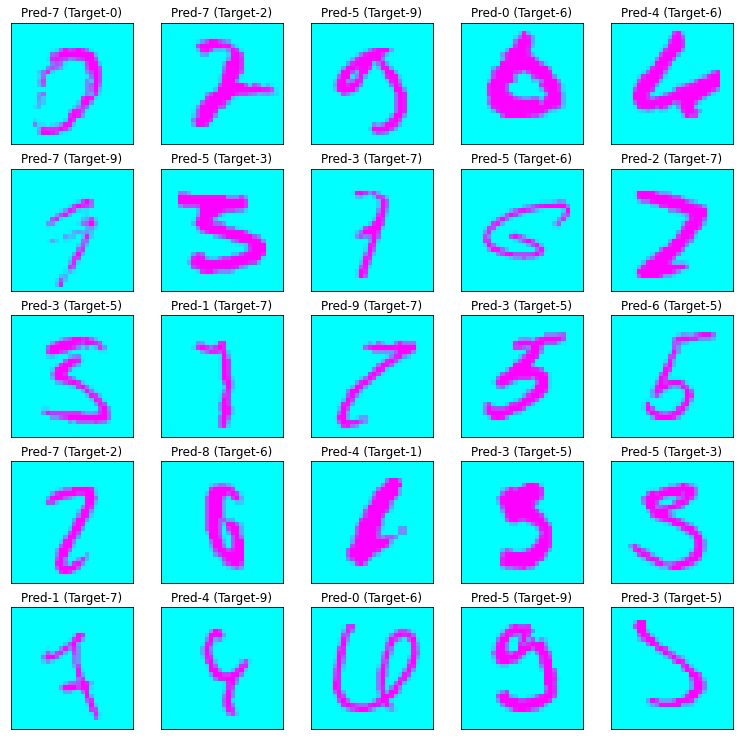

In [22]:
print('Misclassifed Images from Model1')
print('*'*30)

model.load_state_dict(torch.load("model1.pt")) 
misclassifiedOnes(model,'withoutL1_L2_BN.png')
# save_image()

Misclassifed Images from Model2
******************************


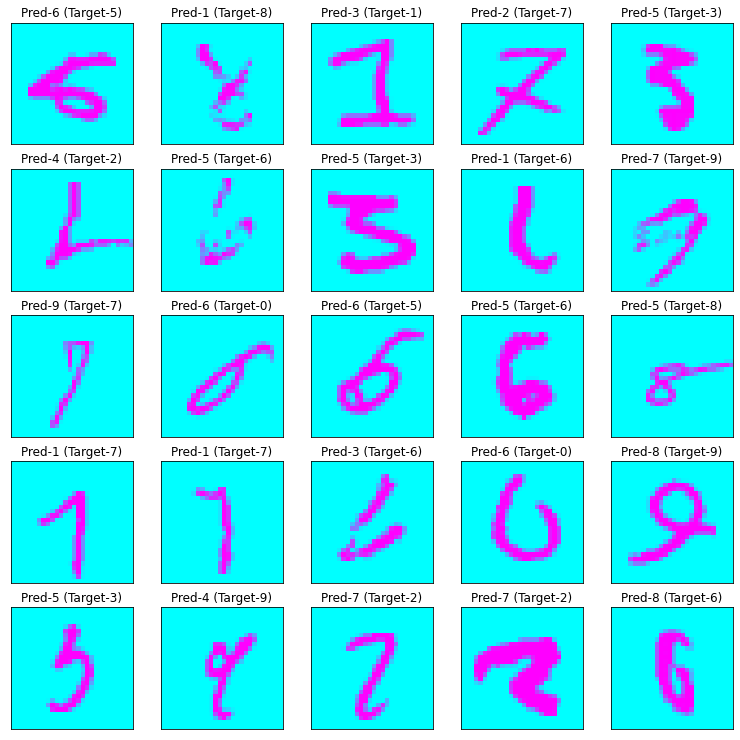

In [23]:
print('Misclassifed Images from Model2')
print('*'*30)

model.load_state_dict(torch.load("model2.pt")) 
misclassifiedOnes(model,'withL1_BN.png')

Misclassifed Images from Model3
******************************


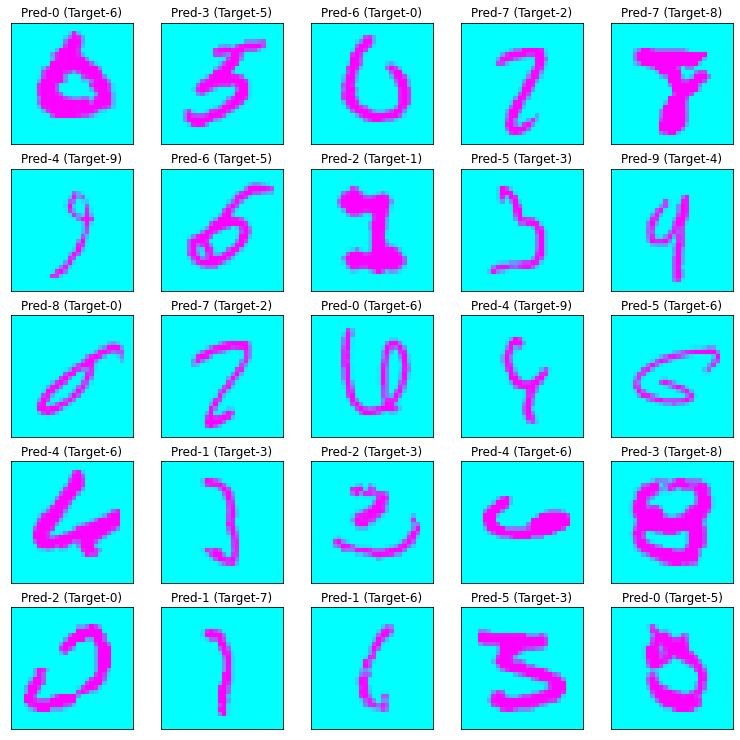

In [24]:
print('Misclassifed Images from Model3')
print('*'*30)
model.load_state_dict(torch.load("model3.pt")) 
misclassifiedOnes(model,'withL2_BN.png')

Misclassifed Images from Model4
******************************


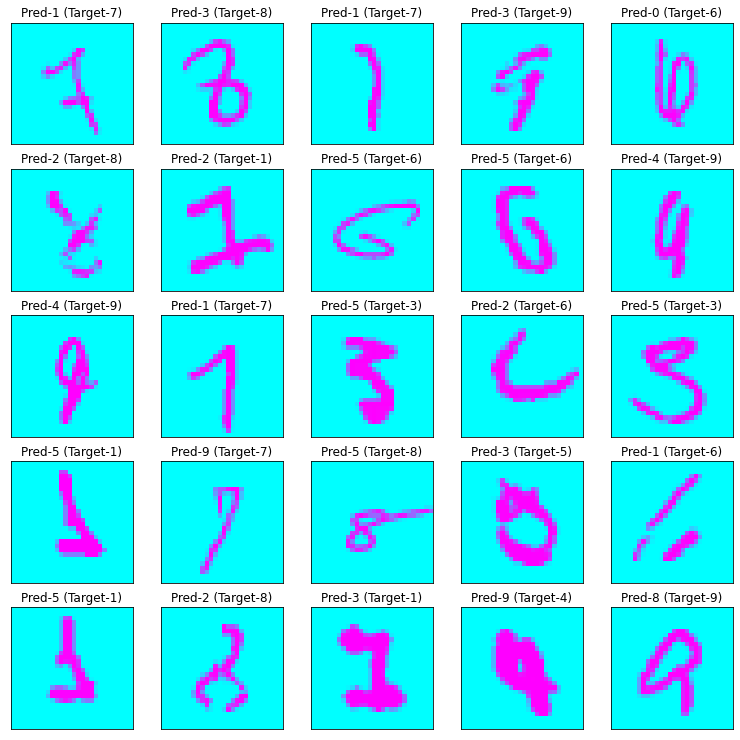

In [25]:
print('Misclassifed Images from Model4')
print('*'*30)

model.load_state_dict(torch.load("model4.pt")) 
misclassifiedOnes(model,'withL1_L2_BN.png')

In [0]:
# DataLoaders

class Dataloader:
  def __init__(self, shuffle = True, batch_size = 64):
      cuda = torch.cuda.is_available()
      if cuda:
        torch.cuda.manual_seed(seed)
      self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) #if cuda else dict(shuffle=True, batch_size=64)

  def dataset_loader(self, data):
      return torch.utils.data.DataLoader(data, **self.dataloader_args) # **dataloader_args get passed when dataset_loader gets called


dl = Dataloader()

# train dataloader
train_loader = dl.dataset_loader(train)

# test dataloader
test_loader = dl.dataset_loader(test)

In [0]:
# Main Model with Ghost Batch Normalization
# use diff batch size for GBN

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          GhostBatchNorm(8,2)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(10,2)) # O/P: 24

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 10
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 8
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 6

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0,  bias = False))
         

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(4))

    
    # Last Layer
      self.convblock9 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.08))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      # x = self.drop(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = self.convblock9(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)
      


# Ghost Batch Normalization

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0) # fill_() helps you filling up the tensor with a particular data
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))
    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)




In [28]:
# GBN Model Summary 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
modelGBN = Net().to(device)
summary(modelGBN, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
    GhostBatchNorm-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
             ReLU-11           [-1, 16, 10, 10]               0
   GhostBatchNorm-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
      self.test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# Model 5

def withoutL1_L2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#first model
  print('without L1 and L2 regularization with GBN')
#without L1 and L2 regularization with GBN

  model5= Test_Train()
  global loss5
  global acc5
  loss5 = model5.test_losses
  acc5 = model5.test_acc

  EPOCHS = 25  
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model5.train(model, device, train_loader, optimizer, epoch, scheduler)
      model5.test(model, device, test_loader,"model5.pt")



In [0]:
# Model 6

def withL1_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#sixth model
  print('with L1 regularization with GBN')
#with L1 regularization with BN
  model6 = Test_Train()
  global loss6
  global acc6
  loss6 = model6.test_losses
  acc6 = model6.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model6.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model6.test(model, device, test_loader,"model6.pt")

In [0]:
#Model 7

def withL2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#seventh model
  print('with L2 regularization with GBN')
#with L2 regularization 
  model7 = Test_Train()
  global loss7
  global acc7
  loss7 = model7.test_losses
  acc7 = model7.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model7.train(model, device, train_loader, optimizer, epoch, scheduler)
      model7.test(model, device, test_loader,"model7.pt")

In [0]:
# Model 8

def withL1_L2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#eighth  model
  print('with L1 & L2 regularization with GBN')
#with both L1 & L2 regularization with BN
  model8 = Test_Train()
  global loss8
  global acc8
  loss8 = model8.test_losses
  acc8 = model8.test_acc

  EPOCHS = 25
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model8.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model8.test(model, device, test_loader,"model8.pt")

**Run all 4 models using an iterator**

In [34]:
GBNmodelTuple5_6 = iter(withoutL1_L2_GBN(),
  withL1_GBN())

# But one problem we've split the this into two model5 & model6, model7 & model8

print(GBNmodelTuple.__next__())

  0%|          | 0/938 [00:00<?, ?it/s]

without L1 and L2 regularization with GBN
EPOCH: 1


Loss=0.2094426304101944 Batch_id=937 Accuracy=91.51: 100%|██████████| 938/938 [01:01<00:00, 15.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0494).  Saving model ...

Test set: Average loss: 0.0494, Accuracy: 9833/10000 (98.33%)

EPOCH: 2


Loss=0.023305311799049377 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [01:00<00:00, 15.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.019049983471632004 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [01:00<00:00, 15.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0494 --> 0.0420).  Saving model ...

Test set: Average loss: 0.0420, Accuracy: 9871/10000 (98.71%)

EPOCH: 4


Loss=0.03555668517947197 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [01:00<00:00, 15.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0420 --> 0.0413).  Saving model ...

Test set: Average loss: 0.0413, Accuracy: 9869/10000 (98.69%)

EPOCH: 5


Loss=0.18498177826404572 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [01:00<00:00, 15.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0413 --> 0.0310).  Saving model ...

Test set: Average loss: 0.0310, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.026606595143675804 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [01:00<00:00, 15.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0310 --> 0.0306).  Saving model ...

Test set: Average loss: 0.0306, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.017328327521681786 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0306 --> 0.0306).  Saving model ...

Test set: Average loss: 0.0306, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.2573164105415344 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [01:00<00:00, 15.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0306 --> 0.0273).  Saving model ...

Test set: Average loss: 0.0273, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.003703838912770152 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [01:00<00:00, 15.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.011140667833387852 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [01:00<00:00, 15.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0273 --> 0.0268).  Saving model ...

Test set: Average loss: 0.0268, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.0005439032684080303 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [01:00<00:00, 15.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0268 --> 0.0252).  Saving model ...

Test set: Average loss: 0.0252, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.026396945118904114 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [01:00<00:00, 15.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.0036914029624313116 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [01:00<00:00, 15.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0252 --> 0.0207).  Saving model ...

Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.018386464565992355 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [01:00<00:00, 15.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9923/10000 (99.23%)

EPOCH: 15


Loss=0.0020237748976796865 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.014352955855429173 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [01:00<00:00, 15.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0207 --> 0.0205).  Saving model ...

Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.01650669053196907 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:04<00:00, 14.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0205 --> 0.0202).  Saving model ...

Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.016514936462044716 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.0004057597543578595 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.11286800354719162 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:00<00:00, 15.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0202 --> 0.0198).  Saving model ...

Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.00035379434120841324 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:59<00:00, 15.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0198 --> 0.0191).  Saving model ...

Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.0026130869518965483 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [01:00<00:00, 15.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0191 --> 0.0183).  Saving model ...

Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.019019590690732002 Batch_id=937 Accuracy=99.49: 100%|██████████| 938/938 [00:59<00:00, 15.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0183 --> 0.0177).  Saving model ...

Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Loss=0.022849394008517265 Batch_id=937 Accuracy=99.51: 100%|██████████| 938/938 [00:59<00:00, 15.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0177 --> 0.0172).  Saving model ...

Test set: Average loss: 0.0172, Accuracy: 9950/10000 (99.50%)

EPOCH: 25


Loss=0.013868257403373718 Batch_id=937 Accuracy=99.53: 100%|██████████| 938/938 [00:59<00:00, 15.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9947/10000 (99.47%)

with L1 regularization with GBN
EPOCH: 1


Loss=0.1312379539012909 Batch_id=937 Accuracy=91.52: 100%|██████████| 938/938 [01:05<00:00, 14.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0510).  Saving model ...

Test set: Average loss: 0.0510, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Loss=0.010781552642583847 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0510 --> 0.0438).  Saving model ...

Test set: Average loss: 0.0438, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.043892115354537964 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [01:02<00:00, 14.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0438 --> 0.0412).  Saving model ...

Test set: Average loss: 0.0412, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


Loss=0.03529411181807518 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [01:02<00:00, 15.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0412 --> 0.0326).  Saving model ...

Test set: Average loss: 0.0326, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.07127917557954788 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [01:02<00:00, 15.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0326 --> 0.0275).  Saving model ...

Test set: Average loss: 0.0275, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.022143706679344177 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [01:02<00:00, 15.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9892/10000 (98.92%)

EPOCH: 7


Loss=0.01541635487228632 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.022281605750322342 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:02<00:00, 15.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.11365101486444473 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.08682450652122498 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [01:01<00:00, 15.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0275 --> 0.0250).  Saving model ...

Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.23807942867279053 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:04<00:00, 14.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9911/10000 (99.11%)

EPOCH: 12


Loss=0.019728830084204674 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [01:01<00:00, 15.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.01652270369231701 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [01:00<00:00, 15.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0250 --> 0.0237).  Saving model ...

Test set: Average loss: 0.0237, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.03712903708219528 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [01:01<00:00, 15.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.02704896219074726 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [01:00<00:00, 15.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0237 --> 0.0211).  Saving model ...

Test set: Average loss: 0.0211, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.31897056102752686 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [01:00<00:00, 15.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.22904625535011292 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [01:00<00:00, 15.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.01973739080131054 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [01:00<00:00, 15.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0211 --> 0.0191).  Saving model ...

Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.05136820301413536 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [01:00<00:00, 15.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9947/10000 (99.47%)

EPOCH: 20


Loss=0.0328015461564064 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [01:04<00:00, 14.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.05679132789373398 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:00<00:00, 15.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0191 --> 0.0183).  Saving model ...

Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

EPOCH: 22


Loss=0.018980352208018303 Batch_id=937 Accuracy=99.49: 100%|██████████| 938/938 [01:00<00:00, 15.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.44%)

EPOCH: 23


Loss=0.01704973354935646 Batch_id=937 Accuracy=99.46: 100%|██████████| 938/938 [01:00<00:00, 15.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0183 --> 0.0176).  Saving model ...

Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.016840998083353043 Batch_id=937 Accuracy=99.49: 100%|██████████| 938/938 [01:00<00:00, 15.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0176 --> 0.0175).  Saving model ...

Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)

EPOCH: 25


Loss=0.017043106257915497 Batch_id=937 Accuracy=99.52: 100%|██████████| 938/938 [00:59<00:00, 15.73it/s]


Validation loss has  decreased (0.0175 --> 0.0171).  Saving model ...

Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)



TypeError: ignored

In [35]:
GBNmodel7_8  = iter(withL2_GBN(),
  withL1_L2_GBN())

print(GBNmodel7_8.__next__())


  0%|          | 0/938 [00:00<?, ?it/s]

with L2 regularization with GBN
EPOCH: 1


Loss=0.07693997770547867 Batch_id=937 Accuracy=92.11: 100%|██████████| 938/938 [01:00<00:00, 15.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0615).  Saving model ...

Test set: Average loss: 0.0615, Accuracy: 9806/10000 (98.06%)

EPOCH: 2


Loss=0.02036621794104576 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [01:01<00:00, 15.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0615 --> 0.0393).  Saving model ...

Test set: Average loss: 0.0393, Accuracy: 9881/10000 (98.81%)

EPOCH: 3


Loss=0.006256876513361931 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [01:00<00:00, 15.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0393 --> 0.0386).  Saving model ...

Test set: Average loss: 0.0386, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.2180730104446411 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [01:00<00:00, 15.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0386 --> 0.0340).  Saving model ...

Test set: Average loss: 0.0340, Accuracy: 9894/10000 (98.94%)

EPOCH: 5


Loss=0.2666285037994385 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [01:00<00:00, 15.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0340 --> 0.0339).  Saving model ...

Test set: Average loss: 0.0339, Accuracy: 9874/10000 (98.74%)

EPOCH: 6


Loss=0.079845130443573 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:59<00:00, 15.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0339 --> 0.0307).  Saving model ...

Test set: Average loss: 0.0307, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.001909708953462541 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:59<00:00, 15.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0307 --> 0.0261).  Saving model ...

Test set: Average loss: 0.0261, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.14699776470661163 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [01:03<00:00, 14.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0261 --> 0.0258).  Saving model ...

Test set: Average loss: 0.0258, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.0070047322660684586 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [01:01<00:00, 15.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.11408375948667526 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [01:01<00:00, 15.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9900/10000 (99.00%)

EPOCH: 11


Loss=0.050061143934726715 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [01:00<00:00, 15.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0258 --> 0.0242).  Saving model ...

Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.04678373411297798 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [01:01<00:00, 15.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.024654565379023552 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0242 --> 0.0227).  Saving model ...

Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.009713450446724892 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [01:03<00:00, 14.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 15


Loss=0.0003672891471069306 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [01:01<00:00, 15.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0227 --> 0.0198).  Saving model ...

Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.06724750995635986 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [01:01<00:00, 15.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0198 --> 0.0186).  Saving model ...

Test set: Average loss: 0.0186, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.21837912499904633 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [01:01<00:00, 15.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0186 --> 0.0183).  Saving model ...

Test set: Average loss: 0.0183, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.011357658542692661 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [01:01<00:00, 15.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.005067579913884401 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:00<00:00, 15.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0183 --> 0.0178).  Saving model ...

Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)

EPOCH: 20


Loss=0.00180238566827029 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:01<00:00, 15.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0178 --> 0.0167).  Saving model ...

Test set: Average loss: 0.0167, Accuracy: 9950/10000 (99.50%)

EPOCH: 21


Loss=0.0015196684980764985 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [01:01<00:00, 15.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0167 --> 0.0161).  Saving model ...

Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)

EPOCH: 22


Loss=0.007768653333187103 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [01:02<00:00, 15.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0161 --> 0.0147).  Saving model ...

Test set: Average loss: 0.0147, Accuracy: 9955/10000 (99.55%)

EPOCH: 23


Loss=0.006507379002869129 Batch_id=937 Accuracy=99.49: 100%|██████████| 938/938 [01:02<00:00, 14.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0147 --> 0.0144).  Saving model ...

Test set: Average loss: 0.0144, Accuracy: 9955/10000 (99.55%)

EPOCH: 24


Loss=0.07514669001102448 Batch_id=937 Accuracy=99.52: 100%|██████████| 938/938 [01:01<00:00, 15.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9953/10000 (99.53%)

EPOCH: 25


Loss=0.0008875456405803561 Batch_id=937 Accuracy=99.53: 100%|██████████| 938/938 [01:02<00:00, 14.98it/s]


Validation loss has  decreased (0.0144 --> 0.0143).  Saving model ...

Test set: Average loss: 0.0143, Accuracy: 9954/10000 (99.54%)



  0%|          | 0/938 [00:00<?, ?it/s]

with L1 & L2 regularization with GBN
EPOCH: 1


Loss=0.03900151327252388 Batch_id=937 Accuracy=90.96: 100%|██████████| 938/938 [01:03<00:00, 14.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0726).  Saving model ...

Test set: Average loss: 0.0726, Accuracy: 9758/10000 (97.58%)

EPOCH: 2


Loss=0.027546266093850136 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [01:02<00:00, 14.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0726 --> 0.0441).  Saving model ...

Test set: Average loss: 0.0441, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.10336568206548691 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [01:03<00:00, 14.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0441 --> 0.0411).  Saving model ...

Test set: Average loss: 0.0411, Accuracy: 9851/10000 (98.51%)

EPOCH: 4


Loss=0.10099826753139496 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [01:03<00:00, 14.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0411 --> 0.0354).  Saving model ...

Test set: Average loss: 0.0354, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.02221737802028656 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [01:03<00:00, 14.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9872/10000 (98.72%)

EPOCH: 6


Loss=0.25315529108047485 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [01:03<00:00, 14.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0354 --> 0.0266).  Saving model ...

Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.02156951278448105 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.16336707770824432 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [01:07<00:00, 13.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.04379840940237045 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [01:03<00:00, 14.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9880/10000 (98.80%)

EPOCH: 10


Loss=0.0543685257434845 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [01:03<00:00, 14.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9893/10000 (98.93%)

EPOCH: 11


Loss=0.03794516623020172 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [01:03<00:00, 14.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9904/10000 (99.04%)

EPOCH: 12


Loss=0.022789474576711655 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [01:02<00:00, 14.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0266 --> 0.0252).  Saving model ...

Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.03238976001739502 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [01:03<00:00, 14.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9911/10000 (99.11%)

EPOCH: 14


Loss=0.01454627700150013 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [01:02<00:00, 14.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9908/10000 (99.08%)

EPOCH: 15


Loss=0.04046786576509476 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:02<00:00, 15.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0252 --> 0.0249).  Saving model ...

Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.014499926939606667 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [01:02<00:00, 15.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0249 --> 0.0233).  Saving model ...

Test set: Average loss: 0.0233, Accuracy: 9921/10000 (99.21%)

EPOCH: 17


Loss=0.0857468917965889 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [01:05<00:00, 14.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0233 --> 0.0192).  Saving model ...

Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.1163216233253479 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [01:02<00:00, 14.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.022120364010334015 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.038381218910217285 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:02<00:00, 14.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Loss=0.012107408605515957 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Validation loss has  decreased (0.0192 --> 0.0162).  Saving model ...

Test set: Average loss: 0.0162, Accuracy: 9953/10000 (99.53%)

EPOCH: 22


Loss=0.01304330863058567 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [01:03<00:00, 14.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.03632363677024841 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [01:03<00:00, 14.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

EPOCH: 24


Loss=0.017947755753993988 Batch_id=497 Accuracy=99.48:  53%|█████▎    | 497/938 [00:34<00:30, 14.67it/s]

Buffered data was truncated after reaching the output size limit.

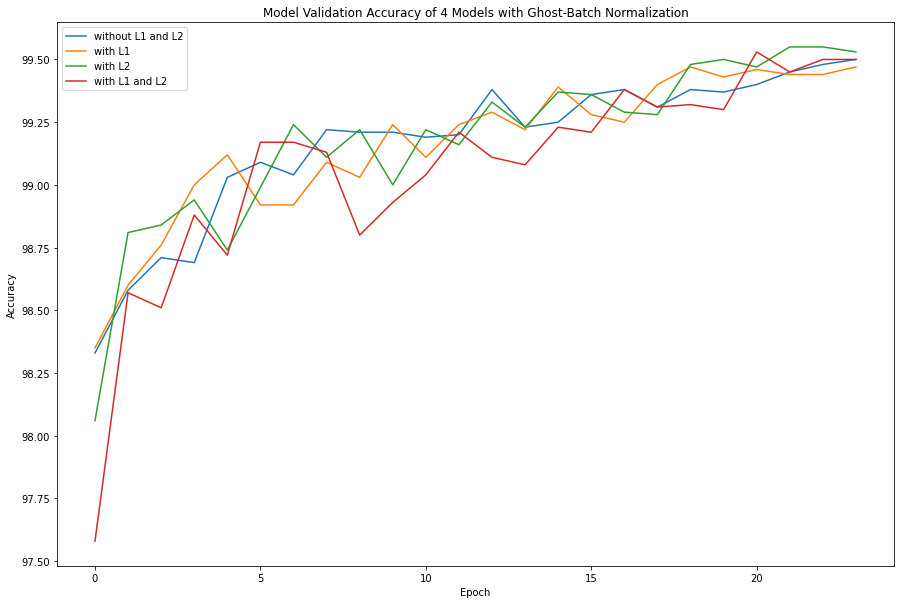

In [36]:
# Validation Accuracy 

class accuracy_plot(Test_Train):

  # a = Test_Train()
  
  def __init__(self):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(acc5[:-1])
    ax.plot(acc6[:-1])
    ax.plot(acc7[:-1])
    ax.plot(acc8[:-1])
    ax.set(title="Model Validation Accuracy of 4 Models with Ghost-Batch Normalization", xlabel="Epoch", ylabel="Accuracy")
    ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
    plt.savefig("Accuracyof4modelswithGBN.png")
    plt.show()

d = accuracy_plot()
d



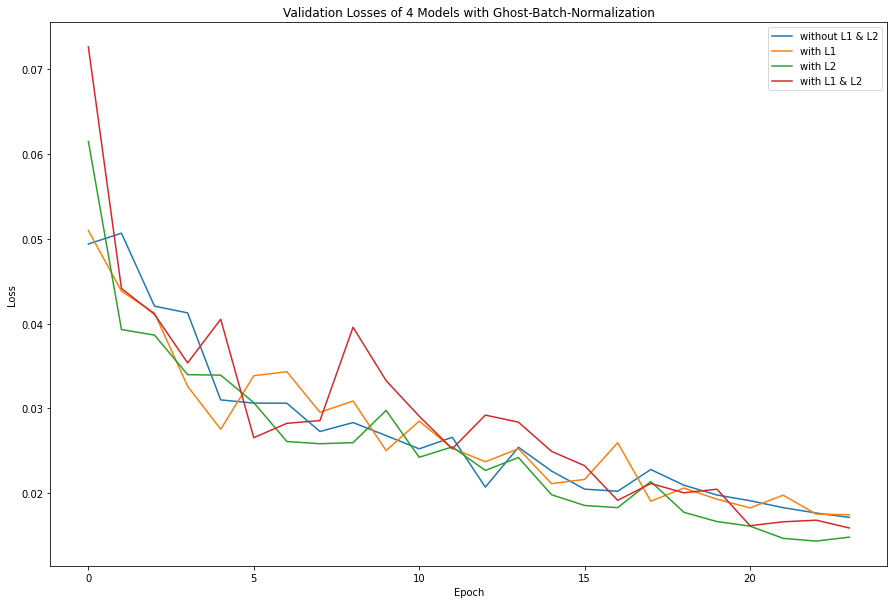

In [37]:
# Validation Loss

class loss_plot(Test_Train):
  def __init__(self):
    plt.figure(figsize = (15,10))
    ax = plt.subplot(111)
    ax.plot(loss5[:-1])
    ax.plot(loss6[:-1])
    ax.plot(loss7[:-1])
    ax.plot(loss8[:-1])
    ax.set(title='Validation Losses of 4 Models with Ghost-Batch-Normalization', xlabel='Epoch', ylabel = 'Loss')
    ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
    plt.savefig('ValidationLossesGBN.png')
    plt.show()

e = loss_plot()
e


In [0]:
# Misclassified Images for GBN

from google.colab import files
def misclassifiedOnesGBN(model, filename):
  model = model.to(device)
  dataiter = iter(test_loader) 
  count = 0
  fig = plt.figure(figsize=(13,13))

  while count<25:
      images, labels = dataiter.next()
      images, labels = images.to(device), labels.to(device)
    
      output = model(images) 
      _, pred = torch.max(output, 1)   # convert output probabilities to predicted class
      images = images.cpu().numpy() # conv images to numpy format

      for idx in np.arange(64):
        if pred[idx]!=labels[idx]:
          ax = fig.add_subplot(5, 5, count+1, xticks=[], yticks=[])
          count=count+1
          ax.imshow(np.squeeze(images[idx]), cmap='cool')
          ax.set_title("Pred-{} (Target-{})".format(str(pred[idx].item()), str(labels[idx].item())), color="Black")
          if count==25:
            break
      plt.savefig(filename)
  files.download(filename)

   


Misclassifed Images from Model5
******************************


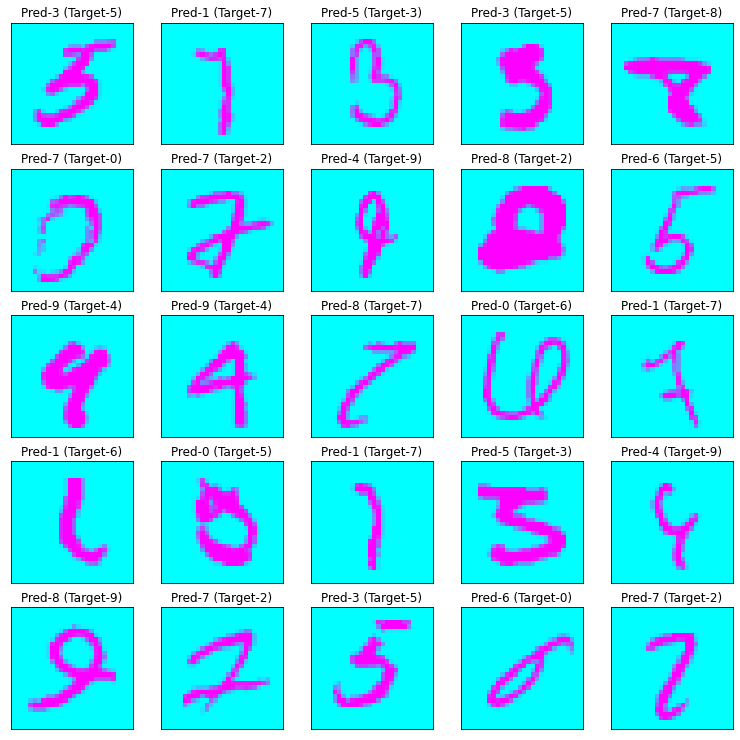

In [50]:
print('Misclassifed Images from Model5')
print('*'*30)

model.load_state_dict(torch.load("model1.pt")) 
misclassifiedOnesGBN(model,'withoutL1_L2_GBN.png')

Misclassifed Images from Model6
******************************


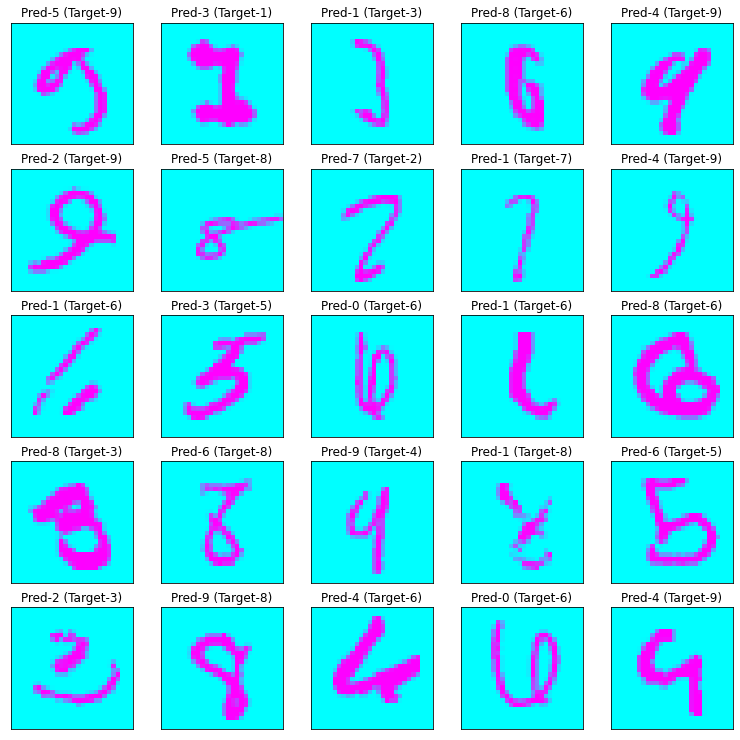

In [53]:
print('Misclassifed Images from Model6')
print('*'*30)

model.load_state_dict(torch.load("model2.pt")) 
misclassifiedOnesGBN(model,'withL1_GBN.png')

Misclassifed Images from Model7
******************************


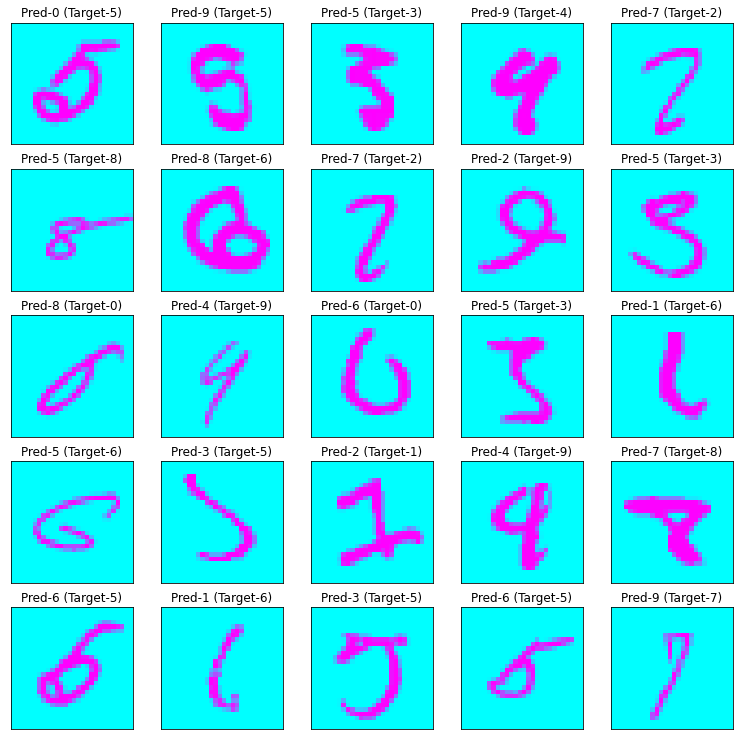

In [52]:
print('Misclassifed Images from Model7')
print('*'*30)

model.load_state_dict(torch.load("model3.pt")) 
misclassifiedOnesGBN(model,'withL2_GBN.png')

Misclassifed Images from Model8
******************************


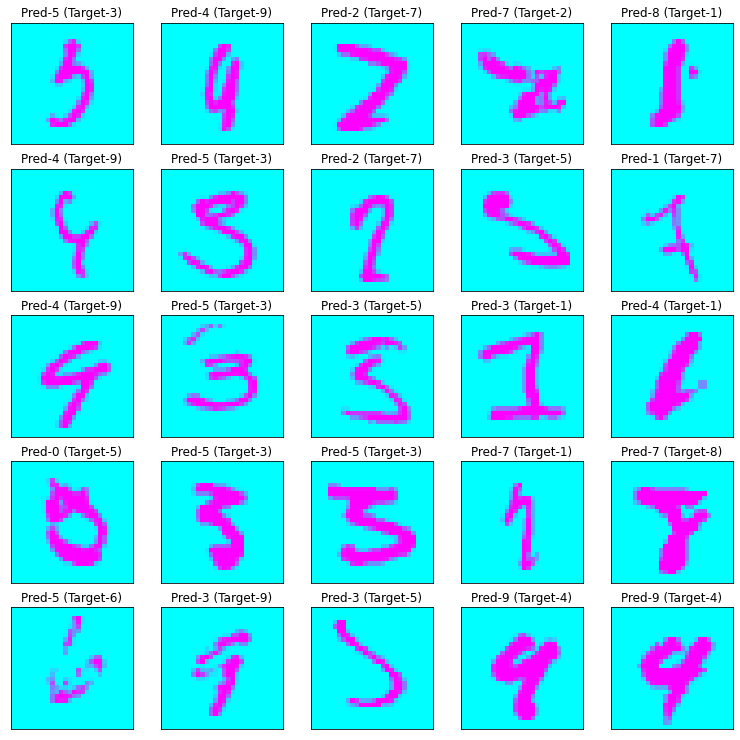

In [54]:
print('Misclassifed Images from Model8')
print('*'*30)

model.load_state_dict(torch.load("model4.pt")) 
misclassifiedOnesGBN(model,'withL1_L2_GBN.png')

**Validation Accuracy Plot for BN & GBN Models**



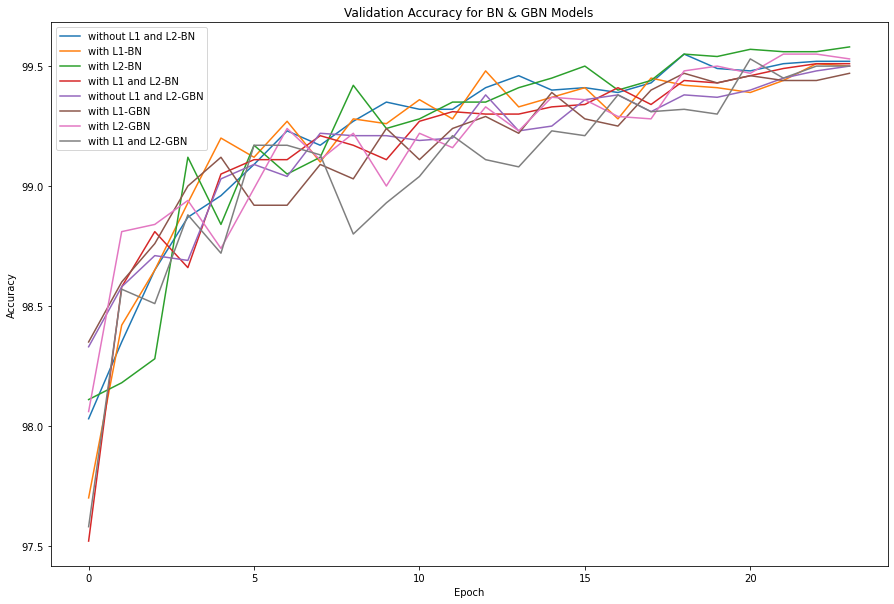

In [56]:
# Validation Accuracy 

class accuracy_plot(Test_Train):

  # a = Test_Train()
  
  def __init__(self):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(acc1[:-1])
    ax.plot(acc2[:-1])
    ax.plot(acc3[:-1])
    ax.plot(acc4[:-1])
    ax.plot(acc5[:-1])
    ax.plot(acc6[:-1])
    ax.plot(acc7[:-1])
    ax.plot(acc8[:-1])
    ax.set(title="Validation Accuracy for BN & GBN Models", xlabel="Epoch", ylabel="Accuracy")
    ax.legend(['without L1 and L2-BN', 'with L1-BN', 'with L2-BN', 'with L1 and L2-BN','without L1 and L2-GBN', 'with L1-GBN', 'with L2-GBN', 'with L1 and L2-GBN'], loc='best')
    plt.savefig("Accuracyof4modelswithBN-GBN.png")
    plt.show()

f = accuracy_plot()
f


**Validation Loss Plot for BN & GBN Models**


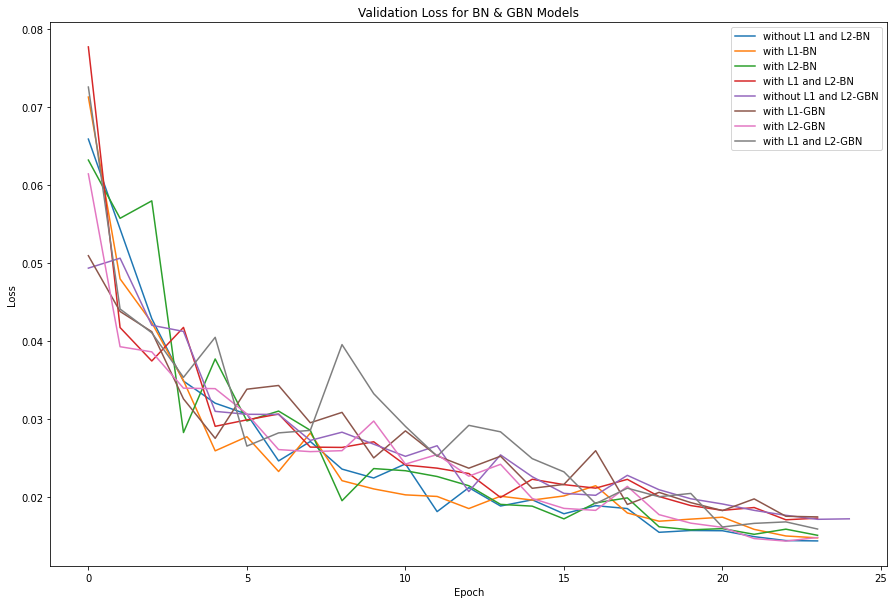

In [58]:
# Validation Accuracy 

class loss_plot(Test_Train):

  # a = Test_Train()
  
  def __init__(self):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.plot(loss1[:-1])
    ax.plot(loss2[:-1])
    ax.plot(loss3[:-1])
    ax.plot(loss4[:-1])
    ax.plot(loss5)[:-1]
    ax.plot(loss6[:-1])
    ax.plot(loss7[:-1])
    ax.plot(loss8[:-1])
    ax.set(title="Validation Loss for BN & GBN Models", xlabel="Epoch", ylabel="Loss")
    ax.legend(['without L1 and L2-BN', 'with L1-BN', 'with L2-BN', 'with L1 and L2-BN','without L1 and L2-GBN', 'with L1-GBN', 'with L2-GBN', 'with L1 and L2-GBN'], loc='best')
    plt.savefig("Accuracyof4modelswithBN-GBN.png")
    plt.show()

g = loss_plot()
g
